**کتابخانه های مورد نیاز در گوگل کلب را نصب کردیم**

In [1]:
!pip install idx2numpy
!conda install -y -c anaconda \
  tensorflow-gpu h5py cudatoolkit=8
!pip install keras

/bin/bash: conda: command not found


**گوگل درایو را مانت کردیم تا به فایل ها دسترسی داشته باشیم**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**کتابخانه ها و فایل ها را فراخوانی کردیم**

In [3]:
import idx2numpy
import numpy as np
import pandas as pd
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential, load_model
from sklearn.model_selection import GridSearchCV
from keras.utils import to_categorical
from keras.utils import np_utils
from keras import backend as K
from keras.optimizers import SGD
import matplotlib
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
filex = 'drive/MyDrive/t10k-images-idx3-ubyte'
filey = 'drive/MyDrive/t10k-labels-idx1-ubyte'
X = idx2numpy.convert_from_file(filex)
y = idx2numpy.convert_from_file(filey)

**طبق گفته صورت سوال 4000 داده اول را برای داده آموزش و بقیه را برای تست جدا کردیم**

In [4]:
X_train = X[:4000]
X_test  = X[4000:]
y_train = y[:4000]
y_test  = y[4000:]

**نمایی از داده ها را می بینیم**

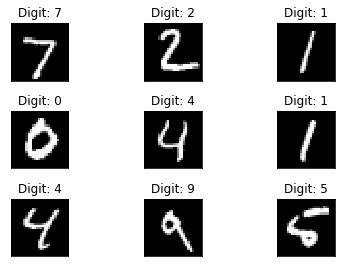

In [5]:
matplotlib.use('agg')
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

**داده ها را نرمال سازی کرده و به صورت مناسب برای پردازش در آوردیم**

In [6]:
# let's print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

# building the input vector from the 28x28 pixels
X_train = X_train.reshape(4000, 784)
X_test = X_test.reshape(6000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)
n_input = X_train.shape[1]
n_class = 10

X_train shape (4000, 28, 28)
y_train shape (4000,)
X_test shape (6000, 28, 28)
y_test shape (6000,)
Train matrix shape (4000, 784)
Test matrix shape (6000, 784)


**تعداد موجودی هر عدد را در دیتاست می بینیم**

In [7]:
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([370, 450, 418, 408, 418, 372, 378, 411, 384, 391]))


**داده ها را با استفاده از وان هات کد کردیم**

In [8]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (4000,)
Shape after one-hot encoding:  (4000, 10)


**همچین شبکه عصبی را با استفاده از گریدسرچ و بدست آوردن هایپرپارامترها  می خواهیم بسازیم که نمای آن را به نمایش گزاشتیم**

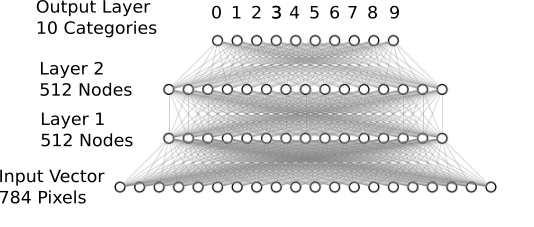

# hyperparameter tuning

**یک مدل کلی در تابع ساختیم که در گرید سرچ بتوانیم از آن استفاده کنیم ، از توابع اکتیویشن ترکیبی استفاده کردیم چون نتیجه بهتری را حاصل میکرد .**

In [12]:
n_epochs = 30  
n_epochs_cv = 10
n_cv = 3
early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, restore_best_weights=True)
# the function takes drop_out rate as argument so we can optimize it  
def create_mlp_model(dropout_rate=0,optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(784,))) 
    # add a dropout layer if rate is not null
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))        
    model.add(Dense(512, activation='sigmoid')) 
    # add a dropout layer if rate is not null    
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))           
    model.add(Dense(10, activation='softmax'))
    
    # Compile model
    model.compile( 
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )    
    return model

**تابعی برای نمایش  پارامتر ها و همچنین بهترین هایپرپارامتر در گرید سرچ به کار گرفتیم**

In [15]:

# define function to display the results of the grid search
def display_cv_results(search_results):
    print('Best score = {:.4f} using {}'.format(search_results.best_score_, search_results.best_params_),'\n\n')
    means = search_results.cv_results_['mean_test_score']
    stds = search_results.cv_results_['std_test_score']
    params = search_results.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print('mean test accuracy +/- std = {:.4f} +/- {:.4f} with: {}'.format(mean, stdev, param))    

**به ازای پارامتر های مختلف با استفاده از گریدسرچ بهترین مدل را به دست آوردیم**

In [16]:
# create model
model = KerasClassifier(build_fn=create_mlp_model, verbose=1)
# define parameters and values for grid search 
param_grid = {
    'batch_size': [16, 32, 64,128],
    'epochs': [n_epochs_cv],
    'dropout_rate': [0.0, 0.20,0.30,0.50],
    'optimizer' : ['sgd','adadelta', 'rmsprop', 'adam','adagrad','adamax']
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=n_cv)
grid_result = grid.fit(X_train, Y_train)  # fit the full dataset as we are using cross validation 
# print out results
display_cv_results(grid_result)

Epoch 1/10
250/250 [==============================] - 1s 2ms/step - loss: 1.0973 - accuracy: 0.6660
Epoch 2/10
250/250 [==============================] - 0s 2ms/step - loss: 0.2540 - accuracy: 0.9202
Epoch 3/10
250/250 [==============================] - 0s 2ms/step - loss: 0.1347 - accuracy: 0.9583
Epoch 4/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0745 - accuracy: 0.9798
Epoch 5/10
250/250 [==============================] - 1s 2ms/step - loss: 0.0481 - accuracy: 0.9862
Epoch 6/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0340 - accuracy: 0.9893
Epoch 7/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9953
Epoch 8/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 9/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.9973
Epoch 10/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9969

**بهترین مدل به دست آمده در گرید سرچ را بر روی داده هایمان فیت کردیم**

In [17]:
# reload best model
mlp = grid_result.best_estimator_ 

# retrain best model on the full training set 
history = mlp.fit(
    X_train,
    Y_train,
    validation_data = (X_test, Y_test),
    epochs = n_epochs,
    callbacks = [early_stop]    
)

Epoch 1/30
250/250 [==============================] - 2s 5ms/step - loss: 1.0186 - accuracy: 0.6887 - val_loss: 0.3375 - val_accuracy: 0.9025
Epoch 2/30
250/250 [==============================] - 1s 4ms/step - loss: 0.2297 - accuracy: 0.9350 - val_loss: 0.3134 - val_accuracy: 0.9095
Epoch 3/30
250/250 [==============================] - 1s 4ms/step - loss: 0.1467 - accuracy: 0.9551 - val_loss: 0.2718 - val_accuracy: 0.9200
Epoch 4/30
250/250 [==============================] - 1s 4ms/step - loss: 0.0893 - accuracy: 0.9707 - val_loss: 0.2477 - val_accuracy: 0.9330
Epoch 5/30
250/250 [==============================] - 1s 4ms/step - loss: 0.0423 - accuracy: 0.9889 - val_loss: 0.2377 - val_accuracy: 0.9390
Epoch 6/30
250/250 [==============================] - 1s 4ms/step - loss: 0.0329 - accuracy: 0.9923 - val_loss: 0.2427 - val_accuracy: 0.9340
Epoch 7/30
250/250 [==============================] - 1s 4ms/step - loss: 0.0107 - accuracy: 0.9980 - val_loss: 0.2296 - val_accuracy: 0.9392
Epoch 

**معیار دقت آموزش وتست را می بینیم**

In [18]:
test_y_pred= mlp.predict(X_test)
train_y_pred= mlp.predict(X_train)
print('Train accuracy : ',accuracy_score(y_train, train_y_pred))
print('Test accuracy : ',accuracy_score(y_test, test_y_pred))

250/250 [==============================] - 0s 970us/step
Train accuracy :  1.0
Test accuracy :  0.9486666666666667


**معیار کلی مدل را روی داده های تست گزارش کردیم**

In [19]:
print(classification_report(y_test, test_y_pred))


              precision    recall  f1-score   support

           0       0.97      0.98      0.98       610
           1       0.99      0.98      0.99       685
           2       0.95      0.92      0.94       614
           3       0.97      0.91      0.94       602
           4       0.92      0.97      0.94       564
           5       0.92      0.91      0.92       520
           6       0.93      0.99      0.96       580
           7       0.94      0.97      0.96       617
           8       0.93      0.93      0.93       590
           9       0.96      0.91      0.93       618

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000



# **بررسی تاثیر انواع توابع فعالیت**

**یک مدل برای تست تاثیر انواع توابع فعالیت در شرایط یکسان ساختیم**

In [20]:
def checkmodel(dropout_rate=0,activation='sigmoid'):
    # create model
    model = Sequential()
    model.add(Dense(512, activation=activation, input_shape=(784,))) 
    model.add(Dense(512, activation=activation)) 
    model.add(Dense(10, activation=activation))
    # Compile model
    model.compile( 
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )    
    return model


**توابع سیگموئید باینری ، سگموئید دو قطبی ، سیگموئید باینری در بازه دلخواه و سیگموئید با شیب متغیر را ساخیتم**

In [21]:
#Custom_Activasion
def binarysigmoid(x):
    return (1 / (1 + 2.718281828459045**(-x)))
def sigmoid2ghotbi(x):
    return ((1 - 2.718281828459045**(-x)) / (1 + 2.718281828459045**(-x)))
def sigmoid_slope(x):
    slope=2
    return (1 / (1 + 2.718281828459045**(slope*(-x))))
def sigmoid_range(x):
    a=5
    b=2
    return (1 / (1 + 2.718281828459045**(a*-x+a*b)))


**معیار صحت را برای آموزش و تست  برای هر تابع فعال ساز را گزارش کردیم**

In [22]:
for i,j in [[binarysigmoid,'binarysigmoid'],[sigmoid2ghotbi,'sigmoid2ghotbi'],[sigmoid_slope,'sigmoid_slope'],[sigmoid_range,'sigmoid_range']]:
  smodel=checkmodel(activation=i)
  history = smodel.fit(X_train, Y_train,batch_size=16, epochs=10,verbose=0,validation_data=(X_test, Y_test))
  test_loss, test_acc = smodel.evaluate(X_test, Y_test)
  train_loss, train_acc = smodel.evaluate(X_train, Y_train)
  print(j," :")
  print('train_acc:', train_acc)
  print('test_acc:', test_acc,'\n')

125/125 [==============================] - 0s 2ms/step - loss: 0.0648 - accuracy: 0.9775
binarysigmoid  :
train_acc: 0.9775000214576721
test_acc: 0.903333306312561 

125/125 [==============================] - 0s 2ms/step - loss: 11.0490 - accuracy: 0.1462
sigmoid2ghotbi  :
train_acc: 0.14624999463558197
test_acc: 0.1538333296775818 

125/125 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 0.9992
sigmoid_slope  :
train_acc: 0.9992499947547913
test_acc: 0.9384999871253967 

125/125 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.9962
sigmoid_range  :
train_acc: 0.9962499737739563
test_acc: 0.9319999814033508 



# بررسی انواع روش های اصلاح وزن و تاثیر روش های تطبیقی کردن نرخ یادگیری

**مدلی ساخته و نرخ یادگیری های مختلف را بر روی آن تست کردیم ، می بینیم که هر چقدر نرخ یادگیری به یک نزدیکتر باشد مدل هم توانسته سریعتر آموزش ببیند و هم نتیجه بهتری حاصل شده است**

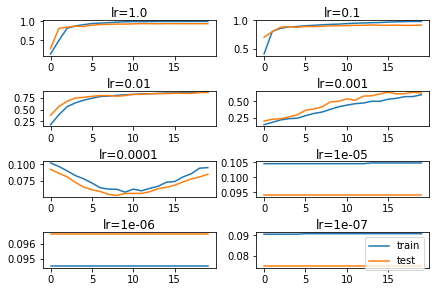

In [23]:
%matplotlib inline
def fit_model(trainX, trainy, testX, testy, lrate):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(784,))) 
    model.add(Dense(512, activation='sigmoid'))           
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr=lrate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=20, verbose=0)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('lr='+str(lrate), pad=-80)
learning_rates = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]
for i in range(len(learning_rates)):
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    fit_model(X_train, Y_train, X_test, Y_test, learning_rates[i])
plt.tight_layout(pad=0.5)
plt.legend()
plt.show()

**اینبار همان مدل را با ضرایب ممنتم مختلف چک کردیم می بینیم که با افزایش ضریب مدل توانسته سریعتر به  آموزش خوبی کسب کند**

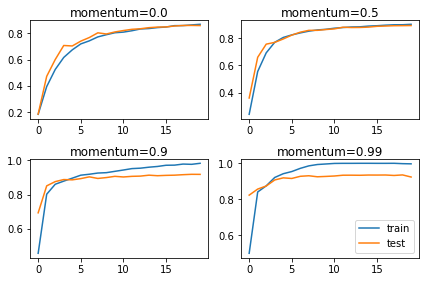

In [24]:
def fit_model(trainX, trainy, testX, testy, momentum):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(784,))) 
    model.add(Dense(512, activation='sigmoid'))           
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr=0.01, momentum=momentum)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=20, verbose=0)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('momentum='+str(momentum), pad=-80)
momentums = [0.0, 0.5, 0.9, 0.99]
for i in range(len(momentums)):
    plot_no = 220 + (i+1)
    plt.subplot(plot_no)
    fit_model(X_train, Y_train, X_test, Y_test, momentums[i])
plt.tight_layout(pad=1.0)
plt.legend()
plt.show()

**می بینیم که مقادیر بزرگ فروپاشی سرعت یادگیری سریع را از بین میبرند و هرچقدر مقادیر کوچک تر باشند میتوانیم سریعتر نتیجه خوبی را کسب کنیم**

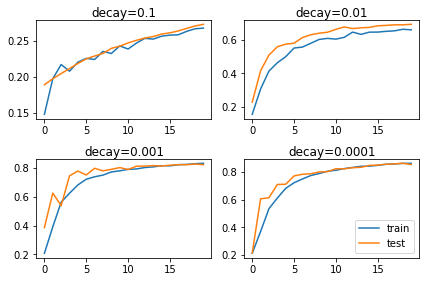

In [25]:
def fit_model(trainX, trainy, testX, testy, decay):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(784,))) 
    model.add(Dense(512, activation='sigmoid'))           
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr=0.01, decay=decay)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=20, verbose=0)

    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('decay='+str(decay), pad=-80)
 

decay_rates = [1E-1, 1E-2, 1E-3, 1E-4]
for i in range(len(decay_rates)):
    plot_no = 220 + (i+1)
    plt.subplot(plot_no)
    fit_model(X_train, Y_train, X_test, Y_test, decay_rates[i])
plt.tight_layout(pad=1.0)
plt.legend()
plt.show()

**در این بخش اپتیمایزر های مختلفی را به کار بردیم میتونیم ببیینیم که روش اس جی دی می تواند مسئله را را یاد بگیرد اما به گام های زیادی نیاز دارد و روش ادادلتا خیلی طول میکشد تا مسئله را یاد بگیرد ولی روش اداگارد نتیجه بهتری دارد ولی باز به گام های زیادی نیازی دارد اما سه روش باقیمانده تقریبا نتایج بهتری را نسبت به بقیه حاصل کرده اند به طوری که سریعتر مسئله را یاد گرفته و سایر گام ها را برای بروز رسانی جزئیات به کار میگیرند**

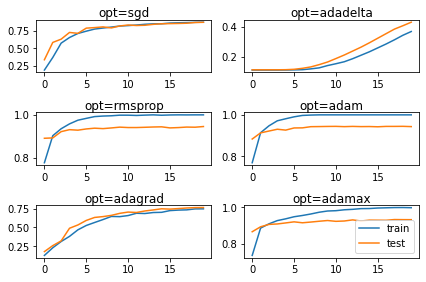

In [26]:
def fit_model(trainX, trainy, testX, testy, optimizer):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(784,))) 
    model.add(Dense(512, activation='sigmoid'))           
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=20, verbose=0)

    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('opt='+optimizer, pad=-80)
# create learning curves for different optimizers
momentums = ['sgd','adadelta', 'rmsprop', 'adam','adagrad','adamax']
for i in range(len(momentums)):
	# determine the plot number
	plot_no = 320 + (i+1)
	plt.subplot(plot_no)
	# fit model and plot learning curves for an optimizer
	fit_model(X_train, Y_train, X_test, Y_test, momentums[i])
# show learning curves
plt.tight_layout(pad=1.0)
plt.legend()
plt.show()